# Проект Агенство недвижимости

К вам обратился представитель крупного агентства недвижимости со
следующей проблемой:
«Мои риелторы тратят катастрофически много времени на сортировку
объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да
и, сказать по правде, качество анализа не дотягивают до уровня конкурентов.
Это сказывается на наших финансовых показателях.

Ваша задача — разработать модель, которая позволила бы обойти
конкурентов по скорости и качеству совершения сделок. 
Необходимо разработать сервис для предсказания стоимости
домов на основе истории предложений.

Для решения поставленной задачи необходимо определять количественную величину(стоимость домов) по определённым параметрам, тип машинного обучения - задача регрессии.

**План проекта:**

**1. Исследование данных** - оценка характеристик предоставленных данных, определение их достаточность, предложение идеи об их использовать

**2. Подготовка данных**  — подготовка обучающей выборки для использования в моделировании после обработки и отбора признаков.

**3. Моделирование** - обучение моделей с получением оценок их качества

**4. Оценка модели** - анализ результатов моделирования, принятие решения о внедрении

**5. Внедрение** - развертывание модели на сервере.


## 1. Исследование данных

In [4]:
%config InlineBackend.figure_format = 'jpeg'
%config InlineBackend.print_figure_kwargs = {'dpi': 72}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import ast
import datetime

from scipy import stats
from scipy.stats import f_oneway, kruskal
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from dmba import AIC_score, stepwise_selection
import plotly.graph_objects as go 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import pickle

In [2]:
data = pd.read_csv(r'data.csv')

data_realt = data.copy()
print(data_realt.shape)
data_realt.head()

(377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
data_realt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Все признаки представлены типом object, в том числе целевой, также имеются пропуски в большинстве признаков.

Сформилируем дальнейшую схему обработки данных на следующем этапе:

1. Привести целевой признак(target) к числовому типу
2. Обработать пропуски в целевом признаке(target)
3. Проанализировать и удалить неинформативные признаки
4. Отдельно обработать информацию в признаках homeFacts и school, содержащие пул данных
5. Обработать пропуски в остальных признаках
6. Спроектировать новые признаки
7. Визуализировать данные, найти зависимости, гипотезы


## 2. Подготовка данных

**target (цена недвижимости)**

In [4]:
# приведем целевой признак target (цена недвижимости) к числовому типу
def target_change(target):
    """ Очищает целевую переменную от посторонних символов и
        возвращает  в формате integer.
        Пропущенные значения оставляет без изменений.
    """
    
    number_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    # создаём новый лист, куда добавляем символы, если они присутствуют в number_list
    target_new = []
    # если нет пропуска, то разбиваем посимвольно и проверяем каждый символ на соответствие number_list
    if target is not np.nan:
        target_list = list(str(target))
        for i in target_list:
            if i in number_list:
               target_new.append(i)
        # соединяем все цифры воедино и преобразуем в формат integer
        target_int = int(''.join(target_new))        
        return target_int
    # если имеется пропущенное значение, то преобразований не проводим
    else:
        return target
    
data_realt['target_clear'] = data_realt['target'].apply(target_change)
# удаляем признак target
data_realt = data_realt.drop(['target'], axis=1)


In [5]:
# подсчитываем число пропусков в target_clear
print(f'Число пропусков в target_clear = {data_realt["target_clear"].isnull().sum()}.')

Число пропусков в target_clear = 2481.


In [6]:
# поскольку число пропусков не велико,  заменим их медианным значением по столбцу
data_realt['target_clear'] = data_realt['target_clear'].fillna(data_realt['target_clear'].median())
print(f'Количество пропусков = {data_realt["target_clear"].isnull().sum()}.')  

Количество пропусков = 0.


In [7]:
# получим описательные статистики по целевой переменной
data_realt['target_clear'].describe()

count    3.771850e+05
mean     6.426214e+05
std      1.835553e+06
min      1.000000e+00
25%      1.889000e+05
50%      3.200000e+05
75%      5.790000e+05
max      1.950000e+08
Name: target_clear, dtype: float64

Имеется недвижимость стоимостью $1, что явно является выбросом. Средняя стоимость недвижимости 642621,4 больше чем в 2 раза медианной 320000.  За меру центральной тенденции будем понимать именно медианное значение цены, так как эта характеристика является устойчивой к выбросам.  

In [ ]:
# построим распределение целевой переменной
fig = px.histogram(
    data_frame=data_realt,
    x='target_clear',    
    title='Distribution of the  target variable',
    text_auto=True,    
    height=600,    
    width=1000,
    nbins=400           
)
fig.show()

Распределение целевой переменной не дало понимания общей картины из-за большого диапазона цен и выбросов. Создадим новый признак на основе логарифмирования целевого, приведя исходное распределение к подобию нормального для удобства.

In [10]:
data_realt['target_clear_log'] = np.log(data_realt['target_clear'])

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='target_clear_log',    
    title='Distribution of the target variable',
    text_auto=True,    
    height=800,    
    width=1000, 
    nbins=100,
    marginal='box'   
)
fig.show()

Избавимся от выбросов по целевому признаку, для этого воспользуемся методом Тьюки, применив его к логарифмированному признаку:

In [12]:
def outliers_iqr(df, feature):
    """ избавление признака feature из датафрейма df от выбросов по методу Тьюки(межквартильный размах)
        возвращает два датафрейма - outliers с выбросами и cleaned очищенный датасет
    """
    x = df[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = df[(x<lower_bound) | (x > upper_bound)]
    cleaned = df[(x>lower_bound) & (x < upper_bound)].reset_index()
    cleaned = cleaned.drop([feature, 'index'], axis=1)
    return outliers, cleaned

outliers, data_realt = outliers_iqr(data_realt, 'target_clear_log')

In [13]:
print(f'Число наблюдений {data_realt.shape[0]}.')
data_realt['target_clear'].describe()

Число наблюдений 349020.


count    3.490200e+05
mean     4.823370e+05
std      4.757567e+05
min      3.525000e+04
25%      2.039500e+05
50%      3.250000e+05
75%      5.690000e+05
max      3.104956e+06
Name: target_clear, dtype: float64

После очистки число наблюдений уменьшилось до 349020, ушли аномальные значения в виде 1 или 195 млн, средняя цена стала больше медианной  только в 1.5 раза.

### неинформативные признаки

Признаки MlsId и mls-id, которые являются уникальными номерами в базе данных в системе множественного листинга цен недвижимости и никакой информативности не несут. Признаки наличия частного бассейна  private pool и PrivatePool, а также признак fireplace содержат порядка 70-90% пропусков и они кандидаты на удаление. Удалим перечисленные признаки:

In [14]:
data_realt = data_realt.drop(['MlsId', 'mls-id', 'private pool', 'PrivatePool', 'fireplace'], axis=1)

In [15]:
data_realt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349020 entries, 0 to 349019
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        310616 non-null  object 
 1   propertyType  319262 non-null  object 
 2   street        349018 non-null  object 
 3   baths         259061 non-null  object 
 4   homeFacts     349020 non-null  object 
 5   city          349000 non-null  object 
 6   schools       349020 non-null  object 
 7   sqft          318875 non-null  object 
 8   zipcode       349020 non-null  object 
 9   beds          273997 non-null  object 
 10  state         349020 non-null  object 
 11  stories       218559 non-null  object 
 12  target_clear  349020 non-null  float64
dtypes: float64(1), object(12)
memory usage: 34.6+ MB


**status (статус продажи), propertyType (тип недвижимости), street (улица)**

In [16]:
# определим наиболее распространенное значение для заполнения пропусков признака status
data_realt['status'].describe()

count       310616
unique         157
top       for sale
freq        144745
Name: status, dtype: object

In [17]:
# заполним пропуски значением for sale
data_realt['status'] = data_realt['status'].fillna(data_realt['status'].describe().top)

In [18]:
# определим наиболее распространенное значение для заполнения пропусков признака propertyType
data_realt['propertyType'].describe()

count                 319262
unique                  1251
top       single-family home
freq                   88107
Name: propertyType, dtype: object

In [19]:
# заполним пропуски значением single-family home
data_realt['propertyType'] = data_realt['propertyType'].fillna(data_realt['propertyType'].describe().top)

In [20]:
# определим наиболее распространенное значение для заполнения пропусков признака street
data_realt['street'].describe()

count                    349018
unique                   311427
top       Address Not Disclosed
freq                        648
Name: street, dtype: object

In [21]:
# заполним пропуски значением Address Not Disclosed
data_realt['street'] = data_realt['street'].fillna(data_realt['street'].describe().top)

In [22]:
# для удобства работы переведём данные в признаках status, propertyType, street в нижний регистр
data_realt['status'] = data_realt['status'].apply(lambda x: x.lower())
data_realt['propertyType'] = data_realt['propertyType'].apply(lambda x: x.lower())
data_realt['street'] = data_realt['street'].apply(lambda x: x.lower())

In [23]:
data_realt['status'].value_counts()

for sale                   224782
active                      94337
foreclosure                  5542
new construction             5323
pending                      4370
                            ...  
coming soon: dec 15.            1
pending w/backup wanted         1
coming soon: dec 25.            1
pending fe                      1
coming soon: dec 23.            1
Name: status, Length: 150, dtype: int64

Большая часть  признака status заполнена 5-ю первыми категориями,
оставим их без изменения, остальные заменим на категорию other

In [24]:
status_list = list(data_realt['status'].value_counts()[:5].index)
data_realt['status'] = data_realt['status'].apply(lambda x: x if x in status_list else 'other')

In [25]:
data_realt['propertyType'].value_counts()[:24]

single-family home               117865
single family                     60789
condo                             40749
single family home                30988
townhouse                         18017
lot/land                          14281
condo/townhome/row home/co-op      7609
multi-family                       7298
land                               5887
traditional                        5843
coop                               3071
multi family                       2620
ranch                              1757
high rise                          1724
detached, one story                1597
single detached, traditional       1569
contemporary                       1533
multi-family home                  1347
mobile/manufactured                1342
1 story                            1233
colonial                           1132
contemporary/modern                 988
mobile / manufactured               932
2 stories                           911
Name: propertyType, dtype: int64

In [26]:
sum(data_realt['propertyType'].value_counts()[:10]/data_realt.shape[0])

0.8862701277863734

Первые наиболее часто встречающие  10 категорий признака propertyType занимают  89 % всех записей
Оставим их без изменения, остальные обозначим other

In [27]:
# лист с категориями
propertyType_list = list(data_realt['propertyType'].value_counts()[:10].index)
data_realt['propertyType'] = data_realt['propertyType'].apply(lambda x: x if x in propertyType_list else 'other')

In [28]:
data_realt['propertyType'].value_counts()

single-family home               117865
single family                     60789
condo                             40749
other                             39694
single family home                30988
townhouse                         18017
lot/land                          14281
condo/townhome/row home/co-op      7609
multi-family                       7298
land                               5887
traditional                        5843
Name: propertyType, dtype: int64

In [29]:
# проводим удаление(замену) ненужных символов 
data_realt['propertyType'] = data_realt['propertyType'].apply(lambda x: ' '.join(x.replace('-', ' ').replace('/', ' ').split(' ')[0:2]))
data_realt['propertyType'] = data_realt['propertyType'].replace('condo townhome', 'condo').replace('lot land', 'land')


In [30]:
data_realt['street']

0                   240 heather ln
1                12911 e heroy ave
2                2005 westridge rd
3              4311 livingston ave
4                1624 s newkirk st
                    ...           
349015       2238 11th st nw apt 2
349016           20800 ne 23rd ave
349017    3530 n lake shore dr #4b
349018           15509 linden blvd
349019            5983 midcrown dr
Name: street, Length: 349020, dtype: object

Преобразуем признак улица(street), избавившись от номеров домов и оставив только наименование улиц - подразумевая, что стоимость недвижимость привязана к местоположению, а наименование улицы один из способов привязаться к этому местоположению. Далее те улицы, которые будут в единственном экземпляре объединим в категорию other.

In [31]:
# приведем подобные по смыслу выражения об отсуствии адреса к  одному выражению
data_realt['street'] = data_realt['street'].replace('undisclosed address', 'address not disclosed').replace('(undisclosed address)', 'address not disclosed')\
    .replace('address not available', 'address not disclosed').replace('unknown address', 'address not disclosed')
    
data_realt['street_new'] = data_realt['street'].apply(lambda x: ' '.join(x.split(' ')[1:4])).replace('', 'address not disclosed').replace('address not disclosed', 'not disclosed')
data_realt = data_realt.drop(['street'], axis=1)


In [32]:
street_list = list(data_realt['street_new'].value_counts()[data_realt['street_new'].value_counts()==1].index)
data_street_one = data_realt[data_realt['street_new'].isin(street_list)]
data_street_one['street_new'] = data_street_one['street_new'].apply(lambda x: 'other')
data_realt = pd.concat(
    [data_realt[~data_realt['street_new'].isin(street_list)], data_street_one],
    ignore_index=True,
    axis=0
)

C:\Users\user\AppData\Local\Temp/ipykernel_17840/1496137909.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**city (город)**

In [33]:
# найдем число пропусков в признаке city
data_realt['city'].isnull().sum()

20

Спарсим данные по городам/штатам/округам/zip-code с сайта http://amerikos.com/geo/?pageNumber=1&pageLimit=120, полученную таблицу, содержащую признаки: Город, Штат, Округ, Индекс, Телефонный код, Часовой пояс, Широта, Долгота, запишем в файл для последующего использования, не прибегая к парсингу

In [34]:
def get_city_inf():
    """ Парсит сайт http://amerikos.com/geo/?pageNumber=1&pageLimit=120 
    с данными по городам/штатам/округам/zip-code

    и возвращает спарсенные данные, упакованные в датафрейм """
    
    # начинаем парсить с первой страницы
    page = 1
    # адрес сайта, в котором будет меняться переменная pageNumber
    url = f'http://amerikos.com/geo/?pageNumber={page}&pageLimit=120'
    # вывод информации о номере страницы
    print(f'Парсим {page} страницу')
    # считываем инфо со страницы - тип данных - лист, в котором необходим элемент 2
    df = pd.read_html(url)[2]
    # временный датафрейм
    df_temp = df    
    # запускаем цикл останавливающийся по условию
    while df_temp['Город'].iloc[0] != 'Не удалось найти города.':
        # увеличиваем счётчик страниц
        page += 1
        # выводим информацию на какой странице находимся
        print(f'Парсим {page} страницу')
        # обновляем адрес страницы
        url = f'http://amerikos.com/geo/?pageNumber={page}&pageLimit=120' 
        # данные записываем во временный датафрейм      
        df_temp = pd.read_html(url)[2]
        # производим объединение датафреймов(основоного и временного) построчно
        df = pd.concat(
            [df, df_temp],
            ignore_index=True,
            axis=0
        )
    # удаляем последнюю неинформативную строку    
    df = df.drop(axis=0, index=(df.shape[0]-1))
    return df
df_pars = get_city_inf()

df_pars.head()

Парсим 1 страницу
Парсим 2 страницу
Парсим 3 страницу
Парсим 4 страницу
Парсим 5 страницу
Парсим 6 страницу
Парсим 7 страницу
Парсим 8 страницу
Парсим 9 страницу
Парсим 10 страницу
Парсим 11 страницу
Парсим 12 страницу
Парсим 13 страницу
Парсим 14 страницу
Парсим 15 страницу
Парсим 16 страницу
Парсим 17 страницу
Парсим 18 страницу
Парсим 19 страницу
Парсим 20 страницу
Парсим 21 страницу
Парсим 22 страницу
Парсим 23 страницу
Парсим 24 страницу
Парсим 25 страницу
Парсим 26 страницу
Парсим 27 страницу
Парсим 28 страницу
Парсим 29 страницу
Парсим 30 страницу
Парсим 31 страницу
Парсим 32 страницу
Парсим 33 страницу
Парсим 34 страницу
Парсим 35 страницу
Парсим 36 страницу
Парсим 37 страницу
Парсим 38 страницу
Парсим 39 страницу
Парсим 40 страницу
Парсим 41 страницу
Парсим 42 страницу
Парсим 43 страницу
Парсим 44 страницу
Парсим 45 страницу
Парсим 46 страницу
Парсим 47 страницу
Парсим 48 страницу
Парсим 49 страницу
Парсим 50 страницу
Парсим 51 страницу
Парсим 52 страницу
Парсим 53 страницу
Па

,Город,Штат,Округ,Индекс,Телефонный код,Часовой пояс,Широта,Долгота
0,65th Infantry,PR,San Juan,923,787,EST+1,18.4125,-66.0374
1,Aaronsburg,PA,Centre,16820,814,EST,40.8639,-77.3918
2,Abbeville,GA,Wilcox,31001,229,EST,31.9896,-83.3111
3,Abbeville,MS,Lafayette,38601,662,CST,34.4719,-89.5985
4,Abbeville,AL,Henry,36310,334,CST,31.555,-85.2655


In [35]:
# Сохраним DataFrame в CSV-файл - промежуточный результата
df_pars.to_csv('df_pars.csv', index=False)

In [36]:
df = pd.read_csv('df_pars.csv')
df.head()

,Город,Штат,Округ,Индекс,Телефонный код,Часовой пояс,Широта,Долгота
0,65th Infantry,PR,San Juan,923,787,EST+1,18.4125,-66.0374
1,Aaronsburg,PA,Centre,16820,814,EST,40.8639,-77.3918
2,Abbeville,GA,Wilcox,31001,229,EST,31.9896,-83.3111
3,Abbeville,MS,Lafayette,38601,662,CST,34.4719,-89.5985
4,Abbeville,AL,Henry,36310,334,CST,31.5550,-85.2655


Используем только столбцы - Город, Округ, Индекс, Широта и Долгота, остальные удалим. Далее соединим таблицы по признаку индекс(zipcode). Обратим внимание на присутствие в признаке индекс(zipcode) значение с пропуском '--', заменим его на 0

In [37]:
df = df[['Город', 'Округ', 'Индекс', 'Широта', 'Долгота']]

data_realt['zipcode'] = data_realt['zipcode'].apply(lambda x: str(0) if x== '--' else x)
data_realt['zipcode'] = data_realt['zipcode'].apply(lambda x: int(x) if len(x.split('-')) < 2  else int(x.split('-')[0]))
# объединяем
data_realt = data_realt.merge(
    df,
    left_on='zipcode',
    right_on='Индекс',    
    how='left'
)

data_realt['city'] = data_realt.apply(lambda x: x.Город if x.city is np.nan else x.city, axis=1)
data_realt['city'] = data_realt['city'].apply(lambda x: data_realt['city'].describe().top if (x=='--') | (x==' ') else x)
# удаляем ненужные столбцы, переименовываем новые
data_realt = (data_realt.drop(['Город', 'Индекс'], axis=1)).rename(columns={'Округ':'county', 'Широта':'latitude', 'Долгота':'longitude'})

In [38]:
data_realt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349020 entries, 0 to 349019
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        349020 non-null  object 
 1   propertyType  349020 non-null  object 
 2   baths         259061 non-null  object 
 3   homeFacts     349020 non-null  object 
 4   city          349020 non-null  object 
 5   schools       349020 non-null  object 
 6   sqft          318875 non-null  object 
 7   zipcode       349020 non-null  int64  
 8   beds          273997 non-null  object 
 9   state         349020 non-null  object 
 10  stories       218559 non-null  object 
 11  target_clear  349020 non-null  float64
 12  street_new    349020 non-null  object 
 13  county        344845 non-null  object 
 14  latitude      344845 non-null  float64
 15  longitude     344845 non-null  float64
dtypes: float64(3), int64(1), object(12)
memory usage: 45.3+ MB


In [39]:
# заменим пропуски в цифровых признаках на среднее значение
data_realt['longitude'] = data_realt['longitude'].fillna(data_realt['longitude'].mean())
data_realt['latitude'] = data_realt['latitude'].fillna(data_realt['latitude'].mean())
# заменим пропуски в признаке округ на частовстречающееся значение
data_realt['county'] = data_realt['county'].fillna(data_realt['county'].describe().top)

**baths (число ванных комнат)**

Преобразуем признак число ваных(baths),который содержит строковые значения и символы, которые требуют обработки, также имеется в числовых значениях(представленых в виде строкового) имеется символ ',' вместо точки. Его  заменим на точку для корректного преобразования в числовой формат(float). Пропущенные значения заменим на медианное.

In [40]:
def convert_baths(df):
    """ Обработчик признака baths  """

        # проверяем на пропущенное значение
    if df  is not np.nan:
        # производим замену симвволов, производим сплит, преобразуем в лист
        df = df.replace(',', '.').split(' ')
        # проходим по каждому элементу листа
        for i in df:
            try:
                i = float(i)
                return i
            # обрабатываем исключение - если элемент невозможно преобразовать в float, то пропускаем
            except ValueError:
                continue  
    else:
        return df
    
data_realt['baths'] = data_realt['baths'].apply(convert_baths)
data_realt['baths'] = data_realt['baths'].fillna(data_realt['baths'].median())

In [41]:
data_realt['baths'].describe()

count    349020.000000
mean          3.056014
std          19.421259
min           0.000000
25%           2.000000
50%           2.250000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

Возможно в признаке baths есть выбросы (число ванных 750!), ограничим их 20.

In [42]:
data_realt = data_realt[data_realt['baths'] < 21].reset_index().drop(['index'], axis=1)
data_realt.shape

(348754, 16)

**sqft (квадратный фут)**

Преобразуем признак квадратный фут (sqft) в числовую форму, учитыавая при обработке, что  в значениях имеются записи в формате: '--', '2500 sqft', '-- sqft', 'Total interior livable area: 2,533 sqft'. Пропущенные значения заменим на медианное.

In [43]:
def convert_sqft(df):
    """ Обрабатывает признак sqft """

    if df is np.nan or df=='--' or df.replace(',', '').split(' ')[0]=='--':
        return np.nan
    if df.replace(',', '').split(' ')[0].lower()=='total':
        df = float(df.replace(',', '').split(' ')[-2])
    else:
        df = float(df.replace(',', '').split(' ')[0])        
    return df

data_realt['sqft_new'] = data_realt['sqft'].apply(convert_sqft)
data_realt['sqft_new'] = data_realt['sqft_new'].fillna(data_realt['sqft_new'].median())
data_realt = data_realt.drop(['sqft'], axis=1)

**stories (число этажей)**

Преобразуем признак число этажей (stories) в числовую форму, учитыавая при обработке, что в нём данные представлены в строковом формате, некоторые признаки прописаны словами, так, например, первый этаж может быть прописан 'One', 'One,' '1 Story', '1.0', есть пропущенные значения, спец. символы, например, '+', записи не содержащие никакие отсылки к этажности(неинформативные) - их заменим на медианное значение.

In [44]:
def convert_stories(df):
    """ Обработчик признака stories  """

    # словарь для замены номеров этажей
    stories_dict = {'One':1, 'Two':2, 'Three':3, 'Tri-Level':3, 'One,':1, '1-2':1.5, 'Bi-Level':2, '3-4':3.5, 'Two,':2, 'Tri':3}
    
    if df is not np.nan:
        df = df.replace('+', '').split(' ')[0]
        if df in stories_dict.keys():
            df = stories_dict[df]
            try:
                df = float(df)
                return df
            except ValueError:
                df = np.nan
                return df
        else:
            try:
                df = float(df)
                return df
            except ValueError:
                df = np.nan
                return df
    else:
        return df
    
data_realt['stories_new'] = data_realt['stories'].apply(convert_stories)
data_realt = data_realt.drop(['stories'], axis=1)

In [45]:
data_realt['stories_new'] = data_realt['stories_new'].fillna(data_realt['stories_new'].median())
data_realt['stories_new'].describe()

count    348754.000000
mean          1.533221
std           3.211153
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1120.000000
Name: stories_new, dtype: float64

В признаке stories_new явно имеются выбросы (число этажей 1120), ограничим признак значением менее 100 этажей, удалив записи, неудовлетворяющие этому условию

In [46]:
data_realt = data_realt[data_realt['stories_new'] < 100].reset_index().drop(['index'], axis=1)
data_realt['stories_new'].describe()

count    348752.000000
mean          1.527145
std           1.963282
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          91.000000
Name: stories_new, dtype: float64

**beds (число комнат)**

Преобразуем признак число комнат (beds) в числовую форму, пропущенные значения заменим на медианное

In [47]:
def convert_beds(df):
    """ Обработчик признака beds """

    beds_list = list(range(0,16))
    if df is not np.nan:
        try:
            df = float(df.replace(',', '.').split(' ')[0])
            if df in beds_list:
                return df
            else:
                return np.nan  
        except ValueError:
            return np.nan    
    else:
        return df
    
data_realt['beds_new'] = data_realt['beds'].apply(convert_beds)      
data_realt = data_realt.drop(['beds'], axis=1)
data_realt['beds_new'] = data_realt['beds_new'].fillna(data_realt['beds_new'].median())    

**Сведения о доме (homeFacts)**

In [48]:
data_realt.iloc[0]['homeFacts']

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Признак homeFacts содержит словарьс ключом atAGlanceFacts, значением которого является список словарей. В каждом словаре содержится два ключа - factLabel (наименование параметра)  и factValue (значение параметра)ю
Имеются следующие виды параметров:
- Year built(год постройки дома)
- Remodeled year(год реконструкции)
- Heating(отопление)
- Cooling(охлаждение)
- Parking(паркинг)
- otsize(дом с участком)
- Price/sqft(цена за квадратный фут)
Разместим все параметры по отдельным признакам с последующим преобразованием


In [49]:
# преобразование строки в словарь
data_realt['homeFacts_new'] = data_realt['homeFacts'].apply(lambda x: ast.literal_eval(x))
# создание новых признаков
data_realt['year_built'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
data_realt['remodeled_year'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
data_realt['heating'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
data_realt['cooling'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
data_realt['parking'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
data_realt['lotsize'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
data_realt['price_sqft'] = data_realt['homeFacts_new'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])
# удаление первначального признака
data_realt = data_realt.drop(['homeFacts'], axis=1)

**year_built (год постройки дома)**

In [50]:
data_realt['year_built'].isnull().sum()

3078

In [51]:
data_realt['year_built'].value_counts()[:20]

        43967
2019    31377
2006     7837
2005     7319
2007     6942
2018     6450
2004     5361
2017     4938
2016     4788
2008     4755
2003     4416
1950     4361
2002     4123
2001     4063
1920     4007
1925     3876
2015     3682
1955     3589
1960     3574
2000     3494
Name: year_built, dtype: int64

имеем 3078(+43967) незаполненных значений. Преобразуем признак в числовой формат и заполним пропуски медианным значением. Также заменим на медианные значения дома года постройки > 2023 года и раньше 1700 года.

In [52]:
data_realt['year_built'] = data_realt['year_built'].apply(lambda x: np.nan if x == '' else np.nan if x == 'No Data' else np.nan if x is None else x)
data_realt['year_built'] = data_realt['year_built'].apply(lambda x: int(x) if x is not np.nan else x)
data_realt['year_built'] = data_realt['year_built'].fillna(data_realt['year_built'].median())
data_realt['year_built'] = data_realt['year_built'].apply(lambda x: data_realt['year_built'].median() if x > 2023 else data_realt['year_built'].median() if x < 1700 else x)

In [53]:
data_realt['year_built'].describe()

count    348752.000000
mean       1980.609476
std          30.739684
min        1700.000000
25%        1962.000000
50%        1985.000000
75%        2005.000000
max        2022.000000
Name: year_built, dtype: float64

Вместо года постройки введем новый признак - возраст

In [54]:
# текущий год
year_current = datetime.datetime.now().year
data_realt['age'] = year_current - data_realt['year_built']

**remodeled_year (год реконструкции)**

In [55]:
data_realt['remodeled_year'].isnull().sum()

25024

In [56]:
data_realt['remodeled_year'] = data_realt['remodeled_year'].apply(lambda x: np.nan if (x == '') | (x == None) else x)
data_realt['remodeled_year'] = data_realt['remodeled_year'].apply(lambda x: int(x) if x is not np.nan else x)

In [57]:
data_realt['remodeled_year'].describe()

count    145942.000000
mean       1979.480122
std          84.362853
min           0.000000
25%        1968.000000
50%        1986.000000
75%        2004.000000
max        2021.000000
Name: remodeled_year, dtype: float64

признак содержит 25024 пропусков, заменим их на медианное значение

In [58]:
data_realt['remodeled_year'] = data_realt['remodeled_year'].fillna(data_realt['remodeled_year'].median())

Дата реконструции не может быть раньше(либо равно) даты постройки, поэтому все значения в признаке remodeled_year, которые не будут соответствовать этому условию заменим на нули.

In [59]:
data_realt['remodeled_year'] = data_realt.apply(lambda x: 0 if x.remodeled_year <= x.year_built else x.remodeled_year, axis=1)

Cоздадим признак на основе remodeled_year - число лет, прошедших с реконструкции(age_remodeled). Обратим внимание, что если в признаке remodeled_year имеется 0, то тогда время реставрации считается с даты постройки дома

In [60]:
data_realt['age_remodeled'] = data_realt.apply(lambda x: (year_current - x.remodeled_year) if x.remodeled_year != 0 else (year_current - x.year_built), axis=1)

Удалим  признаки year_built и remodeled_year.

In [61]:
data_realt = data_realt.drop(['year_built', 'remodeled_year'], axis=1)

**heating (отопление)**

In [62]:
data_realt['heating'].isnull().sum()

3078

In [63]:
data_realt['heating'].value_counts()[:5]

              89144
Forced Air    78786
Forced air    49594
Other         28556
Electric       8851
Name: heating, dtype: int64

В признаке 3078(+89144) пропущенных значений. Так как значения признака текстовые, то приведём их для удобства в нижний регистр:

In [64]:
data_realt['heating'] = data_realt['heating'].apply(lambda x: x.lower() if (type(x) is not float) and (x is not None) else x)
data_realt['heating'] = data_realt['heating'].apply(lambda x: np.nan if (x is None) | (x == 'none') | (x == '') else x)

Избавимся от ненужных символов, возьмём только первые два элемента:

In [65]:
data_realt['heating'] = data_realt['heating'].apply(lambda x: x.replace(',', '') if type(x) is not float else x)
data_realt['heating'] = data_realt['heating'].apply(lambda x: x if (x is np.nan) | (type(x) is float) else ' '.join(x.split(' ')[:2]))

Посмотрим 50 самых распространённых значения:

In [66]:
data_realt['heating'].value_counts()[:50]

forced air               133837
other                     28556
central electric          13732
central air                9728
heat pump                  8912
electric                   8856
gas                        8771
no data                    8236
central                    6197
baseboard                  3727
electric heat              3390
wall                       3213
heating system             2673
natural gas                1590
radiant                    1410
 gas                       1286
central gas                1175
central furnace             909
central heating             822
gas heat                    788
 heat                       546
electric gas                364
central heat                323
refrigeration ceiling       287
refrigeration               254
oil                         213
heat pump(s)                206
baseboard forced            193
baseboard hot               186
gas hot                     178
 electric                   153
hot wate

Унифицируем данные, проведя необходимые замены, далее отберём первые 9 популярных значений, а остальные заменим на other. Пропущенные значения заменим самой распространённой категорией.

In [67]:
data_realt['heating'] = data_realt['heating'].replace('central electric', 'electric').replace(' electric', 'electric').replace('no data', np.nan).replace('electric heat', 'electric')\
    .replace('natural gas', 'gas').replace(' gas', 'gas').replace('central gas', 'gas').replace('gas heat', 'gas').replace('electric gas', 'gas').replace('gas hot', 'gas')\
        .replace('gas -', 'gas').replace('propane', 'gas').replace(' heat', 'heat pump').replace('heating system', 'central').replace('central furnace', 'central')\
            .replace('central heating', 'central').replace('central heat', 'central').replace('heat pump(s)', 'heat pump').replace('radiant', 'central').replace('baseboard forced', 'baseboard')\
                .replace('baseboard hot', 'baseboard')

In [68]:
# лист из 9 самых распространенных категорий
heating_list = list(data_realt['heating'].value_counts()[:9].index)

data_realt['heating'] = data_realt['heating'].apply(lambda x: x if x is np.nan else x if x in heating_list else 'other')
data_realt['heating'] = data_realt['heating'].fillna(data_realt['heating'].describe().top)

In [69]:
data_realt['heating'].value_counts()

forced air     234367
other           34906
electric        26131
gas             14303
central         12334
central air      9728
heat pump        9664
baseboard        4106
wall             3213
Name: heating, dtype: int64

**cooling (охлаждение)**

In [70]:
data_realt['cooling'].isnull().sum()

3078

In [71]:
data_realt['cooling'] = data_realt['cooling'].apply(lambda x: x.lower() if (x is not np.nan) & (x is not None) else x)
data_realt['cooling'] = data_realt['cooling'].apply(lambda x: np.nan if (x is None) | (x == 'none') | (x == '') else x)

In [72]:
data_realt['cooling'].value_counts()[:40]

central                                              153436
central air                                           14256
no data                                               10251
has cooling                                            9276
central electric                                       6107
wall                                                   3908
central gas                                            3547
central heating                                        2800
cooling system                                         2665
central a/c                                            1908
other                                                  1723
central a/c (electric), central heat (gas)             1579
central a/c (electric), central heat (electric)        1350
refrigeration                                          1072
central, electric                                      1060
evaporative                                            1008
electric                                

In [73]:
data_realt['cooling'] = data_realt['cooling'].replace('no data', np.nan).replace('none', np.nan)
data_realt['cooling'] = data_realt['cooling'].apply(lambda x: x if x is np.nan else ' '.join(x.split(' ')[:2]))
data_realt['cooling'] = data_realt['cooling'].apply(lambda x: x.replace(',', '') if type(x) is not float else x)
data_realt['cooling'] = data_realt['cooling'].replace('has cooling', 'cooling').replace('central a/c', 'central air')

Все значения, которые не войдут в 10 самых распространенных категорий обозначим как other, а пропущенные значение заменим самым распространённым значением.

In [74]:
cooling_list = list(data_realt['cooling'].value_counts()[:10].index)
data_realt['cooling'] = data_realt['cooling'].apply(lambda x: x if x is np.nan else x if x in cooling_list else 'other')
data_realt['cooling'] = data_realt['cooling'].fillna(data_realt['cooling'].describe().top)

In [75]:
data_realt['cooling'].value_counts()

central             274329
central air          24118
other                17520
cooling               9276
central electric      8294
central gas           4252
wall                  3908
central heating       3318
cooling system        2665
refrigeration         1072
Name: cooling, dtype: int64

**parking (паркинг)**

In [76]:
data_realt['parking'].isnull().sum()

3078

In [77]:
data_realt['parking'].value_counts()[:50]

                                    151547
Attached Garage                      68334
2 spaces                             27607
1 space                              13951
No Data                              12732
Detached Garage                      12380
Carport                               7530
3 spaces                              4502
Off Street                            3484
Carport, Attached Garage              2894
1                                     2847
4 spaces                              2718
2                                     2683
None                                  2221
Off street                            1581
On Street                             1205
Attached Garage, Detached Garage      1105
0                                      949
Attached Garage, Carport               941
Parking Desc                           875
Driveway                               688
6 spaces                               670
Detached Garage, Attached Garage       594
4          

В признаке 3078(+151547) пропусков и очень много уникальных записей.
Проведём преобразование признака и унификацию категорий, далее оставим 15 самых распространенных, остальные обозначим как other, пропуски заполним топовым значением.

In [78]:
data_realt['parking'] = data_realt['parking'].apply(lambda x: x.lower() if (x is not np.nan) & (x is not None) else x)
data_realt['parking'] = data_realt['parking'].apply(lambda x: np.nan if (x is None) | (x == '') else x)
data_realt['parking'] = data_realt['parking'].replace('no data', np.nan).replace('none', np.nan)
data_realt['parking'] = data_realt['parking'].apply(lambda x: x if x is np.nan else x.replace('+', '').replace(',', '').split(' ')[0])
data_realt['parking'] = data_realt['parking'].replace('driveway', 'off').replace('garage', 'detached')

parking_list = list(data_realt['parking'].value_counts()[:15].index)

data_realt['parking'] = data_realt['parking'].apply(lambda x: x if x is np.nan else x if x in parking_list else 'other')
data_realt['parking'] = data_realt['parking'].fillna(data_realt['parking'].describe().top)

In [79]:
data_realt['parking'].value_counts()

attached    243381
2            31051
1            17048
detached     15329
carport      11499
off           8987
3             5050
other         4650
4             3309
on            2190
parking       2182
0              949
6              867
electric       821
assigned       724
5              715
Name: parking, dtype: int64

**lotsize (дом с участком)**

In [80]:
data_realt['lotsize'].isnull().sum()

26942

In [81]:
data_realt['lotsize'].value_counts()[:20]

               31001
—              22999
No Data         5272
-- sqft lot     3692
0.26 acres      2224
0.28 acres      1912
0.25 acres      1871
0.27 acres      1816
0.29 acres      1715
0.34 acres      1479
6,098 sqft      1469
0.3 acres       1336
7,405 sqft      1328
6,534 sqft      1250
0.31 acres      1231
0.32 acres      1158
10,000 sqft     1152
5,000 sqft      1098
0.33 acres      1033
5,227 sqft      1011
Name: lotsize, dtype: int64

В признаке 26942(+31001)пропущенных значений, но на самом деле их больше, так как имеются неявные пропуски в виде "—", "No Data", "-- sqft lot". Видно, что значения занесены в разных единицах измерения - акры(acres) и квадратные футы(sqft) - переведём всё к одному виду - sqft. Обратим внимание, что где-то имеется разделитель в виде точки, а где-то в виде запятой. После обработки заменим пропущенные значения медианным.

In [82]:
def acr_change(acr):
    """ Переводит акры в квадратные фунты """

    sqft = 43560 * float(acr)
    return sqft

def convert_lotsize(df):
    """ Обработчик признака lotsize

        Возвращает признак в виде float/str
    """
    
    # заменяем пропуски на No и приводим разделитель к общему виду - точки
    df = df.replace('—', 'No').replace('No Data', 'No').replace('-- sqft lot', 'No').replace(',', '')
    
    if df != 'No':
        # приводим строку к нижнему регистру
        df = df.lower()
        # создаём лист со значениями 
        list_temp = df.split(' ')
        # если строка состоит из более чем одного значения, и второе значение 'acres' или 'acre', то переводим в кв фунты
        if (len(list_temp) > 1) and (df.split(' ')[1] == 'acres' or df.split(' ')[1] == 'acre'):
            df = acr_change(list_temp[0])
            return df
        else:
            df = float(list_temp[0])
            return df
    return df

In [83]:
# меняем все пропущенные значения для удобства на No
data_realt['lotsize'] = data_realt['lotsize'].apply(lambda x: 'No' if (x is np.nan) | (x is None) | (x == '') else x)  
# применяем функцию обработчик
data_realt['lotsize'] = data_realt['lotsize'].apply(convert_lotsize)
# все No меняем на np.nan, отрицательные значения на 0
data_realt['lotsize'] = data_realt['lotsize'].apply(lambda x: np.nan if x == 'No' else 0 if x < 0 else x)
# пропуски заменяем на медианное значение
data_realt['lotsize'] = data_realt['lotsize'].fillna(data_realt['lotsize'].describe().median())

**price_sqft (цена за квадратный фут)**

In [84]:
data_realt['price_sqft'].isnull().sum()

42723

In [85]:
data_realt['price_sqft'].value_counts()[:20]

             5004
No Data      1164
No Info       865
$125/sqft     797
$115/sqft     769
$132/sqft     768
$120/sqft     762
$119/sqft     762
$128/sqft     760
$122/sqft     756
$121/sqft     751
$130/sqft     748
$127/sqft     743
$117/sqft     742
$139/sqft     741
$123/sqft     738
$124/sqft     731
$135/sqft     729
$116/sqft     727
$118/sqft     724
Name: price_sqft, dtype: int64

В признаке имеется явный 42723(+5004) пропуск значений и не явный в виде записей 'No Data', 'No Info', которые заменим на np.nan, которые затем заменим медианным значением. 

In [86]:
data_realt['price_sqft'] = data_realt['price_sqft'].apply(lambda x: np.nan if (x == 'No Data') | (x == 'No Info') | (x is None) | (x == '') else x)
data_realt['price_sqft'] = data_realt['price_sqft'].apply(lambda x: x if x is np.nan else float(x.replace('$', '').replace('/', ' ').replace(',', '').split(' ')[0]))

data_realt['price_sqft'] = data_realt['price_sqft'].fillna(data_realt['price_sqft'].median())

In [87]:
# удаляем признак homeFacts_new
data_realt = data_realt.drop(['homeFacts_new'], axis=1)
# для удобства переименовываем признаки
data_realt = data_realt.rename(columns={'street_new':'street', 'sqft_new':'sqft', 'stories_new':'stories', 'beds_new':'beds'})

**schools (школы)**

In [88]:
data_realt.iloc[0]['schools']

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

Признак schools(школы) по структуре похож на признак homeFacts - формат json файла с вложенными словарями и списками в списке содержатся следующие данные:
 - rating(рейтинг школ)
 - data, содержащий сведения:
     - Distance(дистанции до школ, в милях)
     - Grades(уровень школы - младшая/средняя/старшая/и тд)
     - name(наименование школы)

Интерес представляют только признаки rating(рейтинг школ) и Distance(дистанции до школ, в милях). Вначале преобразуем строковое значение в словарь и выделим необходимые данные для создадим двух новых признаков.

In [89]:
data_realt['rating'] = data_realt['schools'].apply(lambda x: ast.literal_eval(x)[0]['rating'])
data_realt['distance'] = data_realt['schools'].apply(lambda x: ast.literal_eval(x)[0]['data']['Distance'])
data_realt = data_realt.drop(['schools'], axis=1)

**rating (рейтинг школ)**

Признак rating представлен в виде списка с рейтингами школ, который  может быть пустым, либо содержать 'NR'(нет рейтинга), 'NA'(нет данных). Создадим обобщающий признак - среднее значение рейтинга школ в данном районе - rating_mean.

In [90]:
def convert_rating(df):
    """ Обработчик признака rating

         Возвращает признак в виде   float/np.nan
    """
    temp_list = []
    list_rating = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    
    if df == []:
        return np.nan
    else:
        for i in df:
            i = i.split('/')[0]
            if i in list_rating:
                temp_list.append(float(i))
        if len(temp_list) ==0:
            rating_mean =0
        else:
            rating_mean = round(np.mean(temp_list), 2)
        return rating_mean   

In [91]:
data_realt['rating_mean'] = data_realt['rating'].apply(convert_rating)
data_realt['rating_mean'] = data_realt['rating_mean'].fillna(round(data_realt['rating_mean'].mean(), 2))
data_realt = data_realt.drop(['rating'], axis=1)

**distance (расстояние до  школ)**

Из данного признака, представленного в виде списка из расстояний до школ создадим два признака - среднее расстояние до школы(distance_mean) и количество школ на районе(schools_count).

In [92]:
def convert_distance(df):
    """ Обработчик признака distance

         возвращет список, содержащий  среднюю дистанцию и количество школ
    """
    temp_list = []
    
    for i in df:
        i = i.split('mi')[0]
        temp_list.append(float(i))
    dist_mean = round(np.mean(temp_list), 2)
    schools_count = len(temp_list)
    return [dist_mean, schools_count]

In [93]:
data_realt['distance_mean'] = data_realt['distance'].apply(lambda x: convert_distance(x)[0])
data_realt['schools_count'] = data_realt['distance'].apply(lambda x: convert_distance(x)[1])
data_realt['schools_count'] = data_realt['schools_count'].apply(lambda x: data_realt['schools_count'].median() if x==0 else x)
data_realt['distance_mean'] = data_realt['distance_mean'].fillna(round(data_realt['distance_mean'].mean(), 2))                                                 
data_realt = data_realt.drop(['distance'], axis=1)

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.



In [94]:
data_realt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348752 entries, 0 to 348751
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         348752 non-null  object 
 1   propertyType   348752 non-null  object 
 2   baths          348752 non-null  float64
 3   city           348752 non-null  object 
 4   zipcode        348752 non-null  int64  
 5   state          348752 non-null  object 
 6   target_clear   348752 non-null  float64
 7   street         348752 non-null  object 
 8   county         348752 non-null  object 
 9   latitude       348752 non-null  float64
 10  longitude      348752 non-null  float64
 11  sqft           348752 non-null  float64
 12  stories        348752 non-null  float64
 13  beds           348752 non-null  float64
 14  heating        348752 non-null  object 
 15  cooling        348752 non-null  object 
 16  parking        348752 non-null  object 
 17  lotsize        348752 non-nul

В очищенном датасете осталось 348752 наблюдения, посмотрим ещё раз на целевую переменную, а далее попытаемся найти зависимости в признаках и сформировать гипотезы/выводы.

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='target_clear',    
    title='Distribution of the target_clear',
    text_auto=True,    
    height=800,    
    width=1000,
    marginal='box'     
)
fig.show()

In [96]:
# асимметрия 
print(data_realt['target_clear'].skew())

2.513574840815391


In [97]:
data_realt['target_clear'].describe()

count    3.487520e+05
mean     4.821910e+05
std      4.756453e+05
min      3.525000e+04
25%      2.037500e+05
50%      3.250000e+05
75%      5.690000e+05
max      3.104956e+06
Name: target_clear, dtype: float64

Распределение целевой переменной стало иметь визуально читаемый вид, но признак ассиметричный - коэффициент ассиметрии положительный(2.51), что говорит о смещении вправо - на графике имеем длинный правый хвост - в котором имеются наблюдения с большим диапазоном разброса цен:
- Медианное значение увеличилось до $325000
- Минимальное - $35250
- Максимальное - $3104956

Связь целевой переменной **target_clear** и **статуса status**

In [ ]:
fig = px.histogram(
    data_frame=data_realt.groupby(['status'], as_index=False)['target_clear'].count(),
    x='status',
    y= ['target_clear'],
    color='status',
    height=500, 
    width=1000, 
    title='Distribution of the attribute status',
    text_auto=True   
)

fig.show()

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['status'], as_index=False)['target_clear'].median(),
    x='status',
    y='target_clear',
    color='status',
    text='target_clear', 
    orientation='v',
    title='Median value of the price from the status',
    height=500, 
    width=1000   
)

fig.show()

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['status'], as_index=False)['distance_mean'].median(),
    x='status',
    y='distance_mean',
    color='status',
    text='distance_mean', 
    orientation='v',
    title='Average distance to school by status',
    height=500, 
    width=1000   
)

fig.show()

В данных основная масса объявлений это со статусом for sale(224754), наименьшая группа pending(4369).
Медианная стоимость недвижимости в зависимости от статуса разнится - наибольшая зафиксирована в категории new construction(449761), что вполне объяснимо - новое, более современное жильё и строится в более перспективных районах города. Стоит отметить и категории foreclosure - недвижимость должников для продажи ниже рынка(242742) и категории незавершенного строительства pending (234900)- возможно недвижимость в непристижных районах/либо далеко от инфраструктуры/школ - на графике видно, что среднее расстояние до школы (1,99 мили) больше, чему у других категорий.

Проведем статистические тесты

In [101]:
# сформируем массивы под каждую категорию
for_sale = data_realt[data_realt['status']=='for sale']['target_clear'].values
active = data_realt[data_realt['status']=='active']['target_clear'].values
foreclosure = data_realt[data_realt['status']=='foreclosure']['target_clear'].values
new_construction = data_realt[data_realt['status']=='new construction']['target_clear'].values
pending = data_realt[data_realt['status']=='pending']['target_clear'].values
other = data_realt[data_realt['status']=='other']['target_clear'].values

In [102]:
# тест Краскела-Уоллиса 
H0 = 'Нет значимой разницы между ценой недвижимости с разными статусами продажи'
H1 = 'Есть значимая разница между ценой недвижимости с разными статусами продажи'

_, p = kruskal(for_sale, active, foreclosure, new_construction, pending, other)

alpha = 0.05

if p > alpha:
    print(f'{p} > {alpha} не можем отвергнуть нулевую гипотезу. {H0}')
else:
    print(f'{p} <= {alpha} отвергаем нулевую гипотезу. {H1}')

0.0 <= 0.05 отвергаем нулевую гипотезу. Есть значимая разница между ценой недвижимости с разными статусами продажи


In [103]:
# тест Данна (NaN означает превышение alpha )
import scikit_posthocs as sp
data = [for_sale, active, foreclosure, new_construction, pending, other]
sp.posthoc_dunn (data, p_adjust = 'bonferroni')[sp.posthoc_dunn (data, p_adjust = 'bonferroni') < 0.05]

,1,2,3,4,5,6
1,NaN,NaN,0.000000e+00,2.635393e-211,3.981281e-169,3.668940e-80
2,NaN,NaN,1.668191e-296,2.610910e-210,2.580254e-160,8.919671e-69
3,0.000000e+00,1.668191e-296,NaN,0.000000e+00,1.118504e-04,1.087807e-109
4,2.635393e-211,2.610910e-210,0.000000e+00,NaN,0.000000e+00,1.136027e-300
5,3.981281e-169,2.580254e-160,1.118504e-04,0.000000e+00,NaN,4.667388e-51
6,3.668940e-80,8.919671e-69,1.087807e-109,1.136027e-300,4.667388e-51,NaN


Статистические тесты показали, что для статуса active нет статистической разницы между active и for sale - но с другими статусами разница имеется.

Связь целевой переменной **target_clear** и типа недвижимости **propertyType**

In [ ]:
fig = px.histogram(
    data_frame=data_realt.groupby(['propertyType'], as_index=False)['target_clear'].count().sort_values(by=['target_clear'], ascending=False),
    x='propertyType',
    y= ['target_clear'],
    color='propertyType',
    height=500, 
    width=1000, 
    title='Distribution of the attribute propertyType',
    text_auto=True   
)

fig.show()

In [105]:
data_realt['propertyType'].value_counts()

single family    209593
condo             48356
other             39493
land              20168
townhouse         18016
multi family       7284
traditional        5842
Name: propertyType, dtype: int64

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['propertyType'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='propertyType',
    y='target_clear',
    color='propertyType',
    text='target_clear', 
    orientation='v',
    title='Median value of the price from the propertyType',
    height=500, 
    width=1000   
)

fig.show()

60% объявлений о продаже недвижимости приходится на категорию single family(на одну семью), также видим, что данный признак существенно влияет на цену недвижимости, для земельных участков(land) она наименьшая - $158000.

Связь целевой переменной **target_clear** и штата **state**

Рассмотрим на распределение объявлений в штатах и зависимость целевой переменной от данного признака.

In [ ]:
fig = px.histogram(
    data_frame=data_realt.groupby(['state'], as_index=False)['target_clear'].count().sort_values(by=['target_clear'], ascending=False),
    x='state',
    y= ['target_clear'],
    color='state',
    height=500, 
    width=1000, 
    title='Distribution of the attribute propertyType',
    text_auto=True   
)

fig.show()

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['state'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='state',
    y='target_clear',
    color='state',
    text='target_clear', 
    orientation='v',
    title='Median value of the price from the state',
    height=500, 
    width=1000   
)

fig.show()

Объявления представлены из 39 разных штатов(из 50), болше всего предложиний из штата Флорида(FL) - более 102 тыс. и штата Техас(TX) - более 81 тыс.

Наибольшая  медианная цена недвижимостив штатах:
- Нью-Йорк (NY) - $725000
- Массачусетс (MA) - $655870
- Калифорния (CA) - $650000
- Округ Колумбия (DC) - $623101
Наменьшая медианная цена недвижимостив штатах:
- Алабама (AL) - $72000
- Монтана (MT) - $82900
- Оклахома (OK) - $114750
- Округ Осэйдж (OS) - $125000
Обоснованно предполагаем о влиянии данного признака на цену недвижимости.

Связь целевой переменной **target_clear** и числом комнат **beds**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='beds',    
    title='Distribution of the beds',
    text_auto=True,    
    height=500,    
    width=1000      
)
fig.show()

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['beds'], as_index=False)['target_clear'].median(),
    x='beds',   
    y='target_clear',
    color='beds',
    title='Scatterplot between beds and target_clear(median)',       
    height=500,    
    width=1000,
    size='target_clear'       
)
fig.show()

Видим зависимость цены недвижимости от числа комнат - при чём до трёх включительно разница небольшая, после трёх видно ускорение в увеличении стоимости: особенно скачок после 4 комнат, после 10 комнат. Опять же с 7 до 10 комнат разница несущественна - возможна связано, с небольшой разницей в общей площади дома и более меньшими площадями самих комнат. Топовое количество комнат - 3(более 197 тыс. объектов). Интересны объекты с 1/9/13 комнатами, где стоимость ниже аналогичных объектов с меньшим количеством комнат.

Связь целевой переменной **target_clear** и числом ванных **baths**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='baths',    
    title='Distribution of the baths',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=20     
)
fig.show()

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['baths'], as_index=False)['target_clear'].median(),
    x='baths',   
    y='target_clear',
    color='baths',
    title='Scatterplot between baths and target_clear(median)',       
    height=500,    
    width=1000,
    size='target_clear'       
)
fig.show()

In [113]:
data_realt['baths'].describe()

count    348752.000000
mean          2.549674
std           1.008295
min           0.000000
25%           2.000000
50%           2.250000
75%           3.000000
max          20.000000
Name: baths, dtype: float64

Основная доля объектов приходится с количеством ванных комнат от 2 до 4(медианное значение 2.25).
Картинка неоднозначная - да, видим, что при увеличении количества ванных комнат растёт и медианная стоимость недвижимости, но интересны некоторые значения, которые выпадают из общего тренда:
участок с 10 по 13 включительно цена наоборот снижается,
значения baths с 17/19/20 - череcчур низкие,
значения 5.2, 4.75, 3.2 - череcчур высокие.
Эти отклонения от тренда возможно связаны с различием цены на недвижимость и количеством предложений по штатам. 

Связь целевой переменной **target_clear** и квадратных футов **sqft**

In [114]:
data_realt['sqft'].describe()

count    3.487520e+05
mean     4.050166e+03
std      7.736118e+05
min      0.000000e+00
25%      1.313000e+03
50%      1.800000e+03
75%      2.453000e+03
max      4.566025e+08
Name: sqft, dtype: float64

Признак sqft имеет большой разброс(квадратичное отклонение 736118) - от 0 до 456602500 квадратных фунтов, при этом медианное значение равняется 1800. 

In [ ]:
# оценим влияние возраста недвижимости на sqft
fig = px.scatter(
    data_frame=data_realt.groupby(['age'], as_index=False)['sqft'].median(),
    y='sqft',   
    x='age',
    color='sqft',
    title='Scatterplot between age and sqft(median)',       
    height=500,    
    width=1000,
    #size='sqft'       
)
fig.show()

По диаграмме видно:
- старые дома(более 120 лет - старше 1900 г) имеют более большой диапазон в площадях домов, они разнятся от года к году, много домов большой площади, далее они приходят к более единой медианной площади. Отметим, что если необходим дом с большой площадью, то стоит его подыскивать именно в этой категории.
- период 30-90 лет характеризуется колебанием от1100 до 1900 футов
- более современный период до 30 лет имеет тенденцию к небольшому росту от 2000 до 2600 футов

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['baths'], as_index=False)['sqft'].median(),
    y='sqft',   
    x='baths',
    color='baths',
    title='Scatterplot between baths and sqft(median)',       
    height=500,    
    width=1000,
    size='sqft'       
)
fig.show()

На диаграмме  имеется участок от 11 до 15 числа комнат, где уменьшается медианная площадь. Это дает объяснение выше рассмотренной зависимости целевой переменной от количества ванных комнат для объектов, у которых стоимость недвижимости снижалось после достижения ванных комнат 9 и до 15. 

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['propertyType'], as_index=False)['sqft'].median().sort_values(by=['sqft'], ascending=False),
    x='propertyType',
    y='sqft',
    color='propertyType',
    text='sqft', 
    orientation='v',
    title='Median value of the sqft from the propertyType',
    height=500, 
    width=1000   
)

fig.show()

Среди типов недвижимости наибольшее по плащади ожидается у multi family, наименьшее - condo.

Связь целевой переменной **target_clear** и этажности **stories**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='stories',    
    title='Distribution of the stories',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=40     
)
fig.show()

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['stories'], as_index=False)['target_clear'].median(),
    x='stories',   
    y='target_clear',
    color='stories',
    title='Scatterplot between stories and target_clear(median)',       
    height=500,    
    width=1000,
    size='target_clear'       
)
fig.show()

Основная часть недвижимости расположена на 2-3 этажах, медианное значение - 1 этаж, что вполне объяснимо так как это частные дома. Имеется плавная прямая зависимость стоимости от этажности строения.

Связь целевой переменной **target_clear** и **heating**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='heating',    
    title='Distribution of the heating',
    text_auto=True,    
    height=500,    
    width=1000        
)
fig.show()

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['heating'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='heating',
    y='target_clear',
    color='heating',
    text='target_clear', 
    orientation='v',
    title='Median value of the target_clear from the heating',
    height=500, 
    width=1000   
)

fig.show()

Самая дорогая недвижимость с отоплением central air, самая дешевая - electric

Связь целевой переменной **target_clear** и **cooling**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='cooling',    
    title='Distribution of the cooling',
    text_auto=True,    
    height=500,    
    width=1000        
)
fig.show()

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['cooling'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='cooling',
    y='target_clear',
    color='cooling',
    text='target_clear', 
    orientation='v',
    title='Median value of the target_clear from the cooling',
    height=500, 
    width=1000   
)

fig.show()

Очевидные выводы следуют из диаграмм аналогично предыдущему случаю с признаком heating

Связь целевой переменной **target_clear** и **parking**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='parking',    
    title='Distribution of the parking',
    text_auto=True,    
    height=500,    
    width=1000        
)
fig.show()

In [ ]:
fig = px.bar(
    data_frame= data_realt.groupby(['parking'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='parking',
    y='target_clear',
    color='parking',
    text='target_clear', 
    orientation='v',
    title='Median value of the target_clear from the parking',
    height=500, 
    width=1000   
)

fig.show()

Более 2/3 недвижимости в признаке parking представлены attached(пристроенный гараж) с медианной стоимостью 324966

In [126]:
data_realt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348752 entries, 0 to 348751
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         348752 non-null  object 
 1   propertyType   348752 non-null  object 
 2   baths          348752 non-null  float64
 3   city           348752 non-null  object 
 4   zipcode        348752 non-null  int64  
 5   state          348752 non-null  object 
 6   target_clear   348752 non-null  float64
 7   street         348752 non-null  object 
 8   county         348752 non-null  object 
 9   latitude       348752 non-null  float64
 10  longitude      348752 non-null  float64
 11  sqft           348752 non-null  float64
 12  stories        348752 non-null  float64
 13  beds           348752 non-null  float64
 14  heating        348752 non-null  object 
 15  cooling        348752 non-null  object 
 16  parking        348752 non-null  object 
 17  lotsize        348752 non-nul

Связь целевой переменной **target_clear** и **rating_mean/schools_count/distance_mean**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='rating_mean',    
    title='Distribution of the rating_mean',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=40      
)
fig.show()

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='schools_count',    
    title='Distribution of the schools_count',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=40        
)
fig.show()

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['rating_mean'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='rating_mean',   
    y='target_clear',
    color='rating_mean',
    title='Scatterplot between rating_mean and target_clear(median)',       
    height=500,    
    width=1000,
    size='target_clear'       
)
fig.show()

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['schools_count'], as_index=False)['target_clear'].median().sort_values(by=['target_clear'], ascending=False),
    x='schools_count',   
    y='target_clear',
    color='schools_count',
    title='Scatterplot between schools_count and target_clear(median)',       
    height=500,    
    width=1000,
    size='target_clear'       
)
fig.show()

In [131]:
data_realt['rating_mean'].describe()

count    348752.000000
mean          5.161618
std           1.934145
min           0.000000
25%           3.670000
50%           5.160000
75%           6.500000
max          10.000000
Name: rating_mean, dtype: float64

In [132]:
data_realt['distance_mean'].describe()


count    348752.000000
mean          2.787196
std           5.960129
min           0.020000
25%           1.040000
50%           1.750000
75%           3.110000
max        1590.830000
Name: distance_mean, dtype: float64

In [133]:
data_realt['schools_count'].describe()

count    348752.000000
mean          4.186927
std           4.349835
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          65.000000
Name: schools_count, dtype: float64

Средний рейтинг школ - 5.16, медианное количество школ около объекта недвижимости - 3, расстояние до которых 1.75 мили. От рейтинга школы зависимость целевой переменной прослеживается. Количество школ в общем не влияет на цену недвижимости, но имеются отдельные выбросы, отклоняющиеся от общего тренда.

Связь целевой переменной **target_clear** и возраста недвижимости **age**

In [ ]:
fig = px.histogram(
    data_frame=data_realt,
    x='age',    
    title='Distribution of the age',
    text_auto=True,    
    height=500,    
    width=1000,
    nbins=50,
    marginal='box'     
)
fig.show()

In [ ]:
fig = px.scatter(
    data_frame=data_realt.groupby(['age'], as_index=False)['target_clear'].median(),
    x='age',   
    y='target_clear',
    color='age',
    title='Scatterplot between age and target_clear(median)',       
    height=500,    
    width=1000,
    #size='target_clear'       
)
fig.show()

In [136]:
data_realt['age'].describe()

count    348752.000000
mean         44.390524
std          30.739684
min           3.000000
25%          20.000000
50%          40.000000
75%          63.000000
max         325.000000
Name: age, dtype: float64

По возрасту недвижимости преобладают объекты 40-49 лет(средний возраст - 44 года). В среднем с увеличением возраста недвижимости прослеживается тенденция к уменьшению её стоимости. Что касается объектов старше 110 лет, то их можно разделить на два класса - те которые имеют цену ниже рыночной - возможно это объекты требующие вложений/реставрации/расположенных в непристижных районах и второй класс - те, которые стоят существенно дороже - какие-то экслюзивные варианты, также имеющие большую площадь/либо большой земельный участок/лучшую локацию.

In [137]:
data_realt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348752 entries, 0 to 348751
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         348752 non-null  object 
 1   propertyType   348752 non-null  object 
 2   baths          348752 non-null  float64
 3   city           348752 non-null  object 
 4   zipcode        348752 non-null  int64  
 5   state          348752 non-null  object 
 6   target_clear   348752 non-null  float64
 7   street         348752 non-null  object 
 8   county         348752 non-null  object 
 9   latitude       348752 non-null  float64
 10  longitude      348752 non-null  float64
 11  sqft           348752 non-null  float64
 12  stories        348752 non-null  float64
 13  beds           348752 non-null  float64
 14  heating        348752 non-null  object 
 15  cooling        348752 non-null  object 
 16  parking        348752 non-null  object 
 17  lotsize        348752 non-nul

В нашем датасете сформировано 24 признака, 9 из которых имеют тип object, закодируем их, далее полученные признаки будем приводить к одному виду - нормировать/стандартизировать. Для начала построим матрицу корреляции для обнаружения линейной связи между целевым признаком и предикторами, а также признаки, которые сильно коррелируют между собой:

<AxesSubplot:>

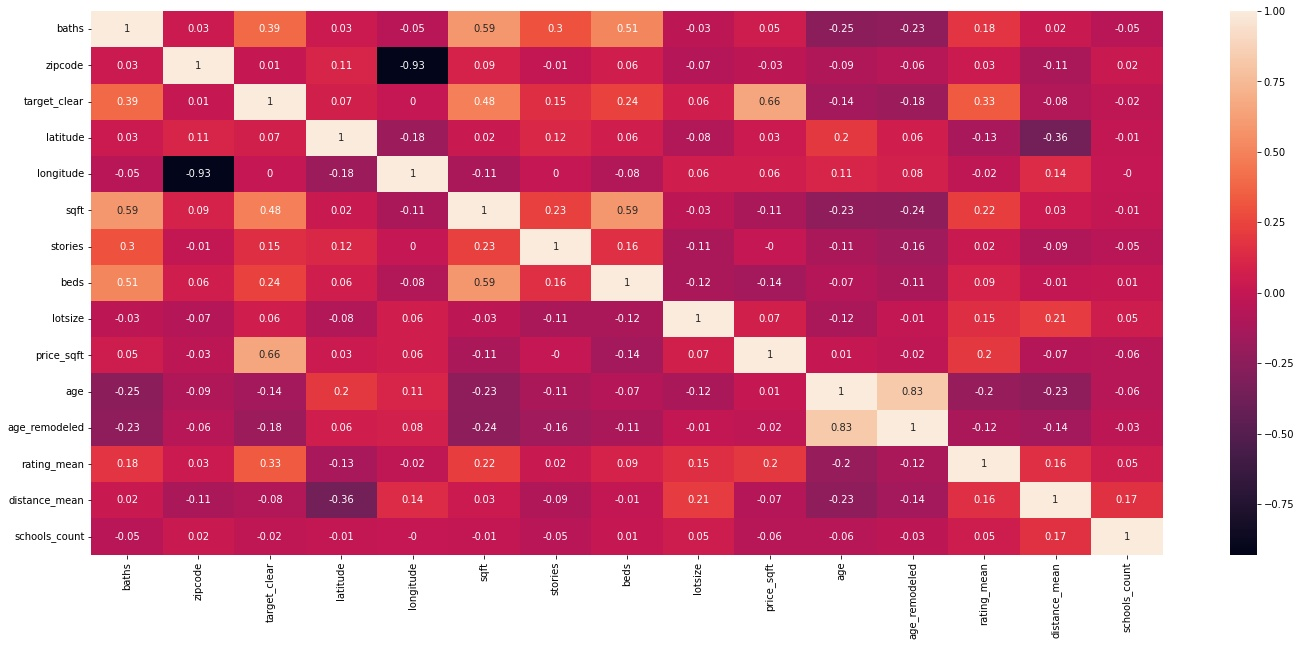

In [138]:
# строим матрицу корреляции
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(data_realt.corr(method='spearman'), 2), annot=True)

Отметим корреляцию целевого признака с:
price_sqft - 0.66
sqft - 0.48
baths - 0.39
rating_mean - 0.33
beds - 0.24
Заметны сильноскореллированные признаки, такие как, age/age_remodeled(0.83), zip_code/longitude(-0.93) - часть из них придётся убрать. Удалим признак price_sqft - через который происходит утечка информации о целевом признаке.
В данных имеются несколько признаков ниже, которые сообщают нам одну и ту же информацию, а именно о локации объекта недвижимости - данный фактор существенен для определения стоимости недвижимости:
city,
state,
zipcode,
county,
latitude,
longitude,
street.
Все признаки типа object, кроме zipcode, latitude, longitude - оставим эти три признака, опеределяющих местоположение, остальные удалим.
Подготовим данные: удалим часть предикторов, необходимые закодируем, далее выборку разделим на тренировочную и тестовую в соотношении 70/30, далее нормализуем данные.

In [139]:
X = data_realt.drop(['city', 'street', 'state', 'county', 'age_remodeled', 'price_sqft', 'target_clear'], axis=1)
y = data_realt['target_clear']
object_columns = [s for s in X.columns if X[s].dtypes == 'object']
X = pd.get_dummies(X, columns=object_columns, drop_first=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42,
    shuffle=True
)

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
X_train_scal = r_scaler.fit_transform(X_train)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = pd.DataFrame(r_scaler.transform(X_test), columns=X_test.columns)

In [140]:
X_train_scal.shape

(244126, 55)

## 3. МОДЕЛИРОВАНИЕ


**Линейная регрессия**

Для начала сформируем базовую модели, которую будем улучшать. Базовая модель будет строиться на всех признаках(55), далее производим предсказание на тренировочных и тестовых данных и проверяем метрики.Будем использовать три метрики - MAE(используем для понимания в абсолютных величинах на сколько в среднем ошибается модель, данную величину легко сравнить с медианной стоимостью недвижимости), MSE и R2 для сравнения моделей между собой.

In [141]:
def metrics_func(y_train, y_train_pred, y_test, y_test_predict):
    """ Возвращает метрики MAE, MSE, R2 для тренировочной и тестовой выборок

        y_train: истинные значения целевой переменной для тренировочной выборки
        y_train_pred: предсказанные значения для тренировочной выборки
        y_test: истинные значения целевой переменной для тестовой выборки
        y_test_predict: предсказанные значения для тестовой выборки
    """
    
    print(f'MAE:')
    print(f'For TRAIN = {round(metrics.mean_absolute_error(y_train, y_train_pred), 2)}')
    print(f'For TEST = {round(metrics.mean_absolute_error(y_test, y_test_predict), 2)}')
    print()
    print(f'MSE:')
    print(f'For TRAIN = {round(metrics.mean_squared_error(y_train, y_train_pred))}')
    print(f'For TEST = {round(metrics.mean_squared_error(y_test, y_test_predict))}')
    print()
    print(f'R2:')
    print(f'For TRAIN = {round(metrics.r2_score(y_train, y_train_pred), 2)}')
    print(f'For TEST = {round(metrics.r2_score(y_test, y_test_predict), 2)}')

In [142]:
model_base = LinearRegression()
model_base.fit(X_train_scal, y_train)
y_train_predict = model_base.predict(X_train_scal)
y_test_predict = model_base.predict(X_test_scal)
metrics_func(y_train, y_train_predict, y_test, y_test_predict)

MAE:
For TRAIN = 258361.9
For TEST = 256237.8

MSE:
For TRAIN = 160214501952
For TEST = 156228215998

R2:
For TRAIN = 0.3
For TEST = 0.3


Базовая модель показала не лучшие метрики - абсолютная ошибка в размере более $256000 величина сильно большая. Коэффицент детерминации неудовлетворительный, меньше 0.5. Поробуем обучить модель на 25 отобранных лучших признаках - для этого используем SelectKBest:

In [143]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train_scal, y_train)
best_features = selector.get_feature_names_out()
best_features

array(['baths', 'latitude', 'longitude', 'stories', 'beds', 'rating_mean',
       'schools_count', 'status_foreclosure', 'status_new construction',
       'status_other', 'status_pending', 'propertyType_land',
       'propertyType_multi family', 'propertyType_townhouse',
       'heating_electric', 'heating_forced air',
       'cooling_central electric', 'cooling_central heating', 'parking_1',
       'parking_3', 'parking_4', 'parking_5', 'parking_6',
       'parking_carport', 'parking_other'], dtype=object)

Интересно отметить, что в список топ-25 не вошли такие признаки, как sqft(площадь дома), который указывает на общий размер недвижимости и zipcode(индекс), который указывает на локацию недвижимости, а она влияет непостедственно на его цену. Без данных признаков модель скорее всего будет несостоятельна.
Также стоит предположить, что данная проблема возникла из-за того, что в алгоритме SelectBest используется корреляция Пирсона, что в данной задаче недопустима из-за того, что целевой признак нераспеределён нормально и необходимо исследовать линейные связи между предикторами и целевой переменной опираясь на корреляцию Спирмена.

По корреляции Спирмена между sqft и target_clear составляет 0.48(можно увидеть на графике корреляции выше), но как будет продемонстрировано ниже, если использовать корреляцию Пирсона, то значение будет близким к нулю -0.00039, поэтому он не отобран в ТОП-25. Что касаемо признака zipcode, то и корреляция Спирмена тоже близка к нулю -0.0082 - здесь дело в том, что данный предиктор хоть и представлен в числовом виде является категориальной переменной и необходимо её использовать именно в виде списка категорий индексов предварительно произведя их разбивку. Пока будем выполнять построение моделей согласно отобранным признакам.

In [144]:
# корреляция Пирсона между sqft/target_clear
np.corrcoef(X_train_scal['sqft'], y_train)


array([[ 1.000000e+00, -3.865881e-04],
       [-3.865881e-04,  1.000000e+00]])

In [145]:
# корреляция Пирсона между zipcode/target_clear
np.corrcoef(X_train_scal['zipcode'], y_train)

array([[ 1.        , -0.00816336],
       [-0.00816336,  1.        ]])

In [146]:
# построим линейную регрессию на 25 признаках
model_1 = LinearRegression()
model_1.fit(X_train_scal[best_features], y_train)
y_train_predict = model_1.predict(X_train_scal[best_features])
y_test_predict = model_1.predict(X_test_scal[best_features])
metrics_func(y_train, y_train_predict, y_test, y_test_predict)

MAE:
For TRAIN = 269573.17
For TEST = 266976.98

MSE:
For TRAIN = 172948942378
For TEST = 168415994699

R2:
For TRAIN = 0.24
For TEST = 0.24


По всем метрикам модель оказалось хуже базовой. 
Попробуем отобрать линейную модель с лучшими признаками, используя метод пошаговой регрессии. Понадобится пакет dmba с импортированными функциями stepwise_selection и метрикой AIC_score. AIC(информационный критерий Акаике) - данная метрика штрафует добавление членов в модель. В нашем случае будем производить поиск оптимальной модели ориентируясь на самый низкий AIC, для этого начнём с построенной модели на константе, вычисляем метрику, далее добавляем один признак, снова расчитываем метрику, далее добавляется следующий и т.д. т.е выполняя таким образом пошаговую регрессию.

In [147]:
def train_model(variables):
    """ Возращает подогнанную модель model для заданного множества переменных variables

    """
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train_scal[variables], y_train)
    return model

def score_model(model, variables):
    """ Возвращает метрику AIC для данной модели model и множества переменных variables

    """
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train_scal[variables]), model)

best_model, best_variables = stepwise_selection(X_train_scal.columns, train_model, score_model, verbose=False)

print(f'Пересечение: {best_model.intercept_:.3f}')
print('Коэффициенты:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f'{name}:{coef}')

Пересечение: 398891.487
Коэффициенты:
baths:191614.6222173001
rating_mean:140939.627604715
latitude:16882.624441169606
age:54270.89565929017
propertyType_single family:-113381.2554441941
propertyType_townhouse:-175966.56370344857
propertyType_land:-165861.69522221934
stories:15971.565917068754
status_for sale:-126675.80860605414
status_foreclosure:-237327.78323373696
heating_forced air:72258.333066426
status_other:-140685.68962683115
heating_central:91813.27227719146
cooling_cooling:54395.66225943761
longitude:-278931.59408080817
zipcode:-369957.69449243095
cooling_central gas:158613.16048931045
propertyType_multi family:69181.09148695803
heating_other:62038.09790024336
schools_count:-2720.240532976808
parking_4:-399679.7425151798
propertyType_other:-64620.278878519195
propertyType_traditional:-134265.0635186421
status_pending:-100514.04446306202
cooling_refrigeration:-209633.14624297968
parking_carport:-558210.1541343716
cooling_central air:-75845.5692080477
cooling_other:-62544.79040

In [148]:
print(len(best_variables))

53


In [149]:
# строим модель на лучших признаках подогнанных с помощью пошаговой регрессии
model_2 = LinearRegression()
model_2.fit(X_train_scal[best_variables], y_train)
y_train_predict = model_2.predict(X_train_scal[best_variables])
y_test_predict = model_2.predict(X_test_scal[best_variables])
metrics_func(y_train, y_train_predict, y_test, y_test_predict)

MAE:
For TRAIN = 258361.64
For TEST = 256238.02

MSE:
For TRAIN = 160215274549
For TEST = 156227318078

R2:
For TRAIN = 0.3
For TEST = 0.3


Метрики совпали с базовой моделью, построенной на всех признаках. Можно сделать вывод об отсуствии явной линейной связи между предикторами и целевым признаком, попробуем усложнить модель добавив полиноминальные признаки.

**Полиномиальная регрессия**

In [150]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=True)

poly.fit(X_train_scal[best_features])
X_train_poly = poly.transform(X_train_scal[best_features])
X_test_poly = poly.transform(X_test_scal[best_features])

model_lin_poly = linear_model.LinearRegression()
model_lin_poly.fit(X_train_poly, y_train)
y_train_pred = model_lin_poly.predict(X_train_poly)
y_test_pred = model_lin_poly.predict(X_test_poly)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)


MAE:
For TRAIN = 249417.95
For TEST = 247996.21

MSE:
For TRAIN = 151829797220
For TEST = 148807748504

R2:
For TRAIN = 0.33
For TEST = 0.33


При построении модели на полиноминальных признаках второй степени метрики улучшились R2 возросло до 0.33/0.33, но MAE по прежнему высоко - $249417, также на лицо улучшение метрик при уходе от линейной закономерности - связь более сложная.

 **Модель деревья решений**

In [151]:
tree_model = tree.DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scal[best_features], y_train)

y_train_pred = tree_model.predict(X_train_scal[best_features])
y_test_pred = tree_model.predict(X_test_scal[best_features])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 60892.33
For TEST = 172367.61

MSE:
For TRAIN = 29138073229
For TEST = 112099291680

R2:
For TRAIN = 0.87
For TEST = 0.5


Построенная модель явно переобучена, поэтому подберём оптимальные параметры глубины дерева.

In [152]:
max_depths = range(7, 20)

def tree_depths(X_train, X_test, y_train, y_test):
  R_2_train = []
  R_2_test = []
  for depth in max_depths:
    tree_model = tree.DecisionTreeRegressor(max_depth=depth, random_state=42).fit(X_train, y_train)
    y_train_pred = tree_model.predict(X_train)
    y_test_pred = tree_model.predict(X_test)
    R_2_tr = round(metrics.r2_score(y_train, y_train_pred), 2)
    R_2_tes = round(metrics.r2_score(y_test, y_test_pred), 2)
    R_2_train.append(R_2_tr)
    R_2_test.append(R_2_tes)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_train, name='Train'))
  fig.add_trace(go.Scatter(x=list(max_depths), y=R_2_test, name='Test'))
  fig.update_xaxes(title='Depth count')
  fig.update_yaxes(title='R_2')
  fig.update_layout(title='Dependence of R_2 on the number of trees', height=600, width=800)
  return fig.show()

tree_depths(X_train_scal, X_test_scal, y_train, y_test)

Выберем за оптимальную глубину - 13 деревьев и построим модель:

In [153]:
tree_model = tree.DecisionTreeRegressor(random_state=42, max_depth=13)
tree_model.fit(X_train_scal[best_features], y_train)

y_train_pred = tree_model.predict(X_train_scal[best_features])
y_test_pred = tree_model.predict(X_test_scal[best_features])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 176066.33
For TEST = 191249.41

MSE:
For TRAIN = 88535781990
For TEST = 105813040728

R2:
For TRAIN = 0.61
For TEST = 0.52


Метрики вновь улучшились, R2 - 0.61/0.52, но обратим внимание, что метрика на тринировочных данных лучше более, чем на 17%, что может говорить о переобучении модели и возможно необходимо снизить глубину.

**Ансамблевые методы**

Первой ансамблевой моделью будет бэггинг и его разновидность - модель случайного леса.

In [154]:
# бэггинг случайный лес
random_forest = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=16,                                               
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal[best_features], y_train)

y_train_pred = random_forest.predict(X_train_scal[best_features])
y_test_pred = random_forest.predict(X_test_scal[best_features])
metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 145113.84
For TEST = 166686.53

MSE:
For TRAIN = 62694598690
For TEST = 84813193832

R2:
For TRAIN = 0.72
For TEST = 0.62


Вторая модель бустинг - AdaBoost.

In [155]:
# бустинг
dt = tree.DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt, #базовая модель
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.01
)
# Обучаем модель
ada.fit(X_train_scal[best_features], y_train)

# Формируем предсказание для тестовой выборки
y_train_pred  = ada.predict(X_train_scal[best_features])
y_test_pred = ada.predict(X_test_scal[best_features])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 262808.43
For TEST = 261430.66

MSE:
For TRAIN = 161295972433
For TEST = 158780919412

R2:
For TRAIN = 0.29
For TEST = 0.29


Третья модель градиентного бустинга.

In [156]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=13, #максимальная глубина дерева
    n_estimators=500, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    learning_rate=0.01
)

# Обучаем модель
gb.fit(X_train_scal[best_features], y_train)

# Формируем предсказание для тестовой выборки

y_train_pred  = gb.predict(X_train_scal[best_features])
y_test_pred = gb.predict(X_test_scal[best_features])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 135136.99
For TEST = 161223.32

MSE:
For TRAIN = 57003662848
For TEST = 82080471585

R2:
For TRAIN = 0.75
For TEST = 0.63


Ещё одна модель бустинга CatBoost.

In [157]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[best_features], y_train)

y_train_pred  = catmodel.predict(X_train_scal[best_features])
y_test_pred = catmodel.predict(X_test_scal[best_features])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 171796.59
For TEST = 173907.54

MSE:
For TRAIN = 86856948073
For TEST = 89056266427

R2:
For TRAIN = 0.62
For TEST = 0.6


Наилучшие результаты показали модели - случайный лес(R2=0.72/0.62), градиентный бустинг(R2=0.75/0.63) и CatBoost(R2=0.62/0.6). Данные модели построены на 25 лучших предикторах, отобранных с помощью SelectBest. Как уже отмечалось ранее после отбора в топ-25 не вошёл такой признак как площадь недвижимости, который по логике должен напрямую влиять на стоимость недвижимости. Воспользуемся CatBoost для построения модели на всех признаках, а далее отберём топ-предикторы согласно их весам.

In [158]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal, y_train)

y_train_pred  = catmodel.predict(X_train_scal)
y_test_pred = catmodel.predict(X_test_scal)

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 126496.7
For TEST = 129577.71

MSE:
For TRAIN = 51648801250
For TEST = 55217300040

R2:
For TRAIN = 0.77
For TEST = 0.75


In [159]:
# признаки и их веса вносимые в модель
best_feature_cat = pd.DataFrame({'feature_importance': catmodel.get_feature_importance(), 
              'feature_names':X_train_scal.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
# топ-11 признаков по весам
new_best = best_feature_cat['feature_names'].iloc[:11]
best_feature_cat[:11]

,feature_importance,feature_names
4,21.240447,sqft
3,18.830605,longitude
2,15.357914,latitude
1,15.070298,zipcode
0,6.594647,baths
8,4.642446,age
9,4.385562,rating_mean
7,3.794084,lotsize
5,1.727175,stories
10,1.538484,distance_mean


По степени значимости на первом месте площадь недвижимости(sqft). Далее построим отмеченные ранее модели на новых топ-11 признаках.

In [160]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scal[new_best], y_train)

y_train_pred  = catmodel.predict(X_train_scal[new_best])
y_test_pred = catmodel.predict(X_test_scal[new_best])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)


MAE:
For TRAIN = 128732.57
For TEST = 132010.29

MSE:
For TRAIN = 53349145563
For TEST = 57058532357

R2:
For TRAIN = 0.77
For TEST = 0.74


In [161]:
random_forest = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=13,                                               
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scal[new_best], y_train)

y_train_pred = random_forest.predict(X_train_scal[new_best])
y_test_pred = random_forest.predict(X_test_scal[new_best])
metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 135492.95
For TEST = 148711.68

MSE:
For TRAIN = 51482479888
For TEST = 65688990747

R2:
For TRAIN = 0.77
For TEST = 0.7


In [162]:
# визуализируем важные признаки в дереве решений
oo = pd.DataFrame([random_forest.feature_importances_], columns=X_train_scal[new_best].columns)
fig = px.bar( 
    x=list(oo.loc[0].sort_values(ascending=False).index),
    y=round(oo.loc[0].sort_values(ascending=False), 2),
    text_auto=True,
    title='ТОП-11 features for RandomForest',
    height=500, 
    width=1000,
    labels={'x':'feature_importances', 'y':'weight'}
       
)
fig.show()

In [163]:
# градиентный бустинг

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=9, #максимальная глубина дерева
    n_estimators=500, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел
    learning_rate=0.01
)

# Обучаем модель
gb.fit(X_train_scal[new_best], y_train)

# Формируем предсказание для тестовой выборки

y_train_pred  = gb.predict(X_train_scal[new_best])
y_test_pred = gb.predict(X_test_scal[new_best])

metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 123563.54
For TEST = 132629.17

MSE:
For TRAIN = 46597215243
For TEST = 56885521015

R2:
For TRAIN = 0.8
For TEST = 0.74


In [164]:
# визуализируем важные признаки в градинетном бустинге
aa = pd.DataFrame([gb.feature_importances_], columns=X_train_scal[new_best].columns)
fig = px.bar( 
    x=list(aa.loc[0].sort_values(ascending=False).index),
    y=round(aa.loc[0].sort_values(ascending=False), 2),
    text_auto=True,
    title='ТОП-11 features for GradientBoosting',
    height=500, 
    width=1000,
    labels={'x':'feature_importances', 'y':'weight'}
       
)
fig.show()

In [165]:
#X_train_scal[new_best].columns
missing = set(new_best) - set(X_train_scal.columns)
if missing:
    print(f"Отсутствующие колонки: {missing}")
# Убедитесь, что new_best содержит допустимые имена колонок
valid_columns = [col for col in new_best if col in X_train_scal.columns]
print(valid_columns)
print(new_best)


['sqft', 'longitude', 'latitude', 'zipcode', 'baths', 'age', 'rating_mean', 'lotsize', 'stories', 'distance_mean', 'beds']
4              sqft
3         longitude
2          latitude
1           zipcode
0             baths
8               age
9       rating_mean
7           lotsize
5           stories
10    distance_mean
6              beds
Name: feature_names, dtype: object


In [166]:
# Создание матриц наблюдений в формате DMatrix
valid_columns = [col for col in new_best if col in X_train_scal.columns]
dtrain = xgb.DMatrix(X_train_scal[new_best], label=y_train, feature_names=valid_columns)
dtest = xgb.DMatrix(X_test_scal[new_best], label=y_test, feature_names=valid_columns)

# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dtest, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #ранняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

y_train_predict = model_xgb.predict(dtrain)
y_test_predict = model_xgb.predict(dtest)

metrics_func(y_train, y_train_predict, y_test, y_test_predict)

[0]	train-rmse:455414.03076	valid-rmse:449595.52497
[10]	train-rmse:344313.87057	valid-rmse:341031.41517
[20]	train-rmse:309832.12599	valid-rmse:308447.01423
[30]	train-rmse:293666.16678	valid-rmse:293220.24417
[40]	train-rmse:283152.85261	valid-rmse:283432.54566
[50]	train-rmse:276106.89104	valid-rmse:276908.62876
[60]	train-rmse:270635.28411	valid-rmse:271984.56675
[70]	train-rmse:267320.79038	valid-rmse:269158.09267
[80]	train-rmse:262858.61968	valid-rmse:265260.48034
[90]	train-rmse:260441.77812	valid-rmse:263243.64839
[100]	train-rmse:256958.08260	valid-rmse:260265.85041
[110]	train-rmse:253871.94002	valid-rmse:257576.85345
[120]	train-rmse:251643.66168	valid-rmse:255767.23426
[130]	train-rmse:249197.32004	valid-rmse:253800.73263
[140]	train-rmse:246943.72964	valid-rmse:251958.91872
[150]	train-rmse:245436.21120	valid-rmse:250828.06710
[160]	train-rmse:244161.95875	valid-rmse:249940.69000
[170]	train-rmse:242488.25115	valid-rmse:248572.62899
[180]	train-rmse:241173.25861	valid-rms

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

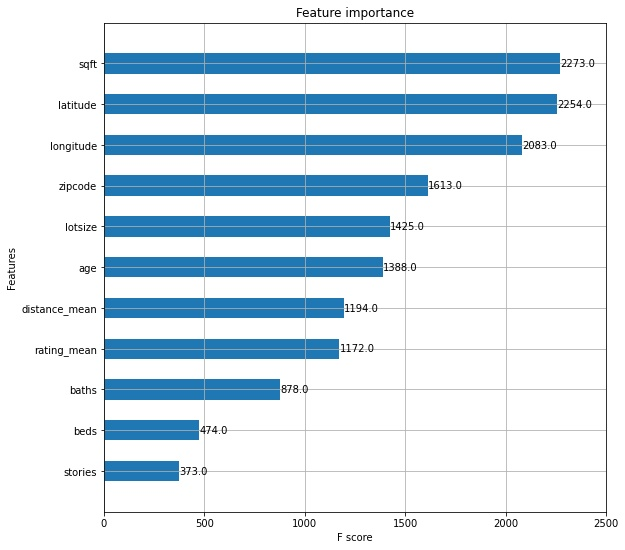

In [167]:
fig, ax = plt.subplots(figsize = (9,9))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)

## 4. Оценка Модели

Создадим таблицу со сводными данными по построенным моделям, выделив шрифтом модели с лучшими результатами. Принципиально по метрикам практическая разница несущественна, поэтому для дальнейшего развёртывания выберем модель RandomForestRegressor TOP-11 - у неё есть преимущества - нет необходимости производить нормализацию признаков, допускает параллельные  вычисления, нет склонности к переобучению.

<font color='green'>**Модель/Метрика**</font>       |<font  color='green'>**R2**   </font>|<font color='green'>**MSE**</font>
:------|:-------:|:-
**Baseline** |    0.30/0.30|  160214 501952/156228 215998
**LinearRegression TOP-25** |    0.24/0.24|  172948 942378/168415 994699
**LinearRegression best_variables** |    0.30/0.30|  160215 274549/156227 318078
**PolinominalFeature** |    0.33/0.33|  151829 797220/148807 748504
**DecisiontreeRegressor TOP-25** |    0.61/0.52|  88535 781990/105813 040728
**RandomForestRegressor TOP-25** |    0.72/0.62|  62694 598690/84813 193832
**AdaBoost TOP-25** |    0.29/0.29|  161295 972433/158780 919412
**GradientBoostingRegressor TOP-25** |    0.75/0.63|  57003 662848/82080 471585
**CatBoost TOP-25** |    0.62/0.60|  86856 948073/89056 266427
**CatBoost TOP-11** |   **0.77/0.74**|  **53349 145563/57058 532357**
**RandomForestRegressor TOP-11** |    **0.77/0.70**|  **51482 479888/65688 990747**
**GradientBoostingRegressor TOP-11** |    **0.80/0.74**|  **46597 215243/56885 521015**
**XGB TOP-11** |    **0.77/0.74**|  **52244 442908/57179 829086**


В итоге нам удалось повысить качество моделирования по сравнению с базовой моделью. Мы выбрали модель, оценили ей качество, приняли решение о внедрении, но в дальнейшем данную модель возможно усовершенствовать и улучшить, так, например:
1. Вернуться к признакам и провести дополнительные проверки на логическую непротиворечивость между собой, для признака площадь дома(sqft), играющего большую роль в модели, оценить необходимость удаления выбросов, и т.п.
2. В моделировании попробовать стекинг с импользованием разных базовых моделей.
3. Разделить датасет на несколько выборок(по целевому признаку), и построить для каждой свою модель, определить метрики.
4. Дополнить в дальнейшем dataset дополнительными признаками, которые очевидно влияют на стоимость недвижимости: необходимость ремонта/нет, угловая квартира/нет, выполнен дизайнерский ремонт/нет и т.п.

## 5. Внедрение

При подготовке модели к внедрению напишем веб-сервер(server.py) на Flask, реализующий модель RandomForestRegressor с 11 признаками, а также клиентский сервис(client.py) для проверки. 
Для начала переобучим нашу модель на ненормализованных данных так как в модель будем подавать именно их, и сериализуем модель в файл:

In [168]:
random_forest_noscal = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=13,                                               
                                               criterion='squared_error',
                                               random_state=42)

random_forest_noscal.fit(X_train[new_best], y_train)

y_train_pred = random_forest_noscal.predict(X_train[new_best])
y_test_pred = random_forest_noscal.predict(X_test[new_best])
metrics_func(y_train, y_train_pred, y_test, y_test_pred)

MAE:
For TRAIN = 135492.26
For TEST = 148708.42

MSE:
For TRAIN = 51481392433
For TEST = 65685120312

R2:
For TRAIN = 0.77
For TEST = 0.7


In [169]:
# сериализация модели
with open('model.pkl', 'wb') as output:
    pickle.dump(random_forest_noscal, output)

Тестирование веб-сервера заключалось в проверке совпадения предсказаний из ответа веб-сервера и модели в блокноте jupyter на отдельных записях из X_train и X_test, вводимых вручную в приложении client.py. Результаты тестирования подтвердили правильность функционирования веб-сервера. 